In [174]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
# https://www.countyhealthrankings.org/health-data/community-conditions/health-infrastructure/clinical-care/primary-care-physicians?year=2025&state=48&tab=1

In [175]:
data = pd.read_csv('texas-2025-primary-care-physicians-place-sort.csv')
data[data.isnull().any(axis=1)]

keep_row = data.iloc[0]
data = data.dropna().copy()
data.iloc[0] = keep_row
# or 
# filtered_data = pd.concat([keep_row, data.iloc[1:].dropna()])
data


,County,# Primary Care Physicians,County Value**,National Z-Score
1,Texas,"17,818","1,660:1",NaN
2,Andrews,9,"2,050:1",0.15
3,Angelina,57,"1,520:1",-0.32
4,Aransas,8,"3,060:1",0.59
6,Armstrong,0,"1,840:0",1.49
...,...,...,...,...
248,Winkler,2,"3,710:1",0.75
249,Wise,27,"2,660:1",0.45
250,Wood,15,"3,060:1",0.59
251,Yoakum,2,"3,800:1",0.77


In [176]:
def ratio(input):
    left, right = input.split(':')
    left = left.replace(',','')
    right = right.replace(',','')
    return round((float(right)/float(left) * 100),4)

data.rename(columns={'County Value**': 'Physician:Population'}, inplace=True)
data['Physician:Population'] = data['Physician:Population'].apply(ratio) 

In [177]:
data.drop(1, inplace=True)
data.reset_index(drop=True, inplace=True)
data

,County,# Primary Care Physicians,Physician:Population,National Z-Score
0,Andrews,9,0.0488,0.15
1,Angelina,57,0.0658,-0.32
2,Aransas,8,0.0327,0.59
3,Armstrong,0,0.0000,1.49
4,Atascosa,10,0.0200,0.94
...,...,...,...,...
215,Winkler,2,0.0270,0.75
216,Wise,27,0.0376,0.45
217,Wood,15,0.0327,0.59
218,Yoakum,2,0.0263,0.77


Graph z-scores with respect to each county (see which counties have more or less people per physician based on z-score)

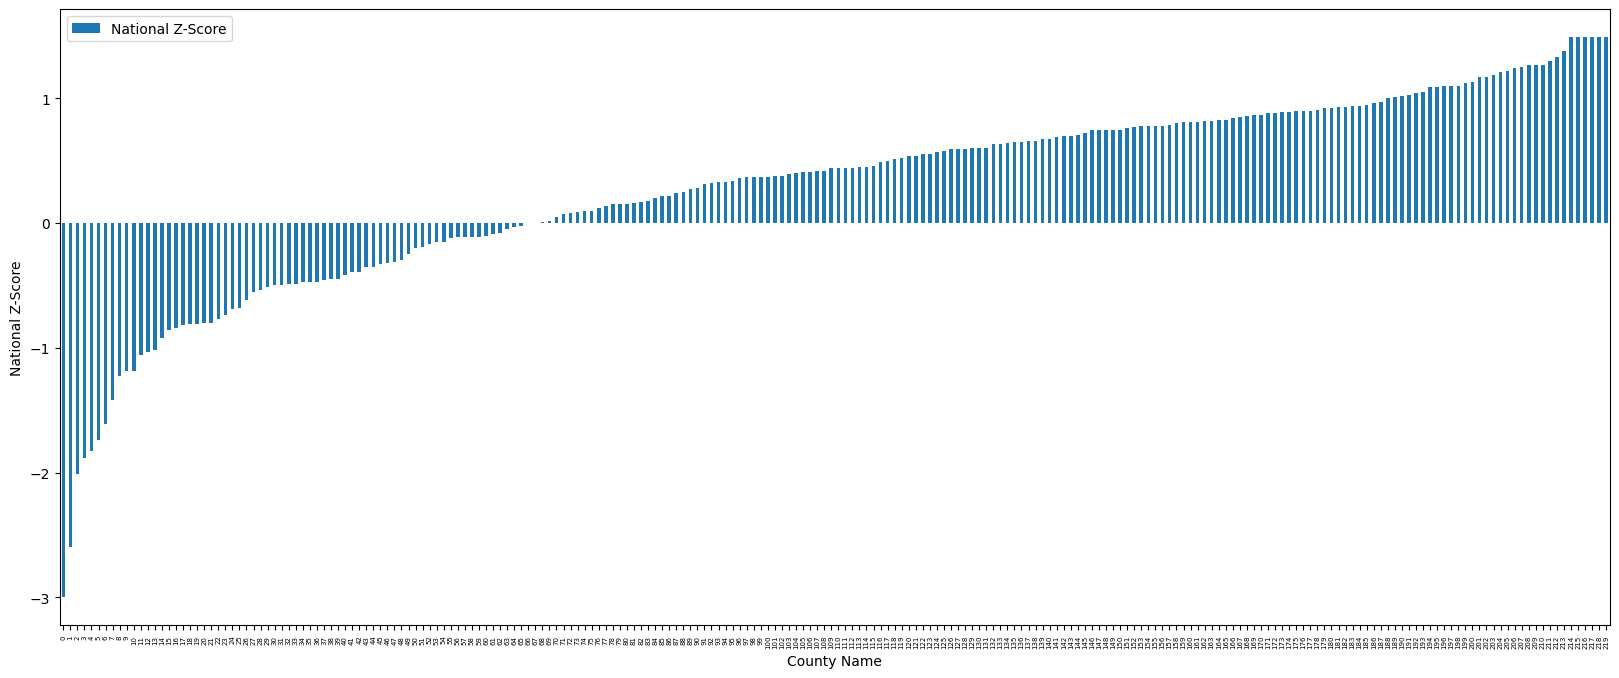

In [178]:
data.sort_values('National Z-Score', inplace=True)

def clean(input):
    if '^' in input:
        newinput = input.replace('^','')
        return newinput
    else:
        return input 
data['County (new)'] = data['County'].apply(clean)
data.reset_index(drop=True, inplace=True)
anotherdata = data.copy()
anotherdata.set_index('County (new)', inplace=True)
fig,ax = plt.subplots(figsize=(10,8))
data.plot(kind='bar', y='National Z-Score', figsize=(20,8), ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=5)
ax.set_xlabel('County Name')
ax.set_ylabel('National Z-Score')
plt.show()

Combine this data with demographics data to see if counties with lower physician:population metrics also tend to have more minorities 

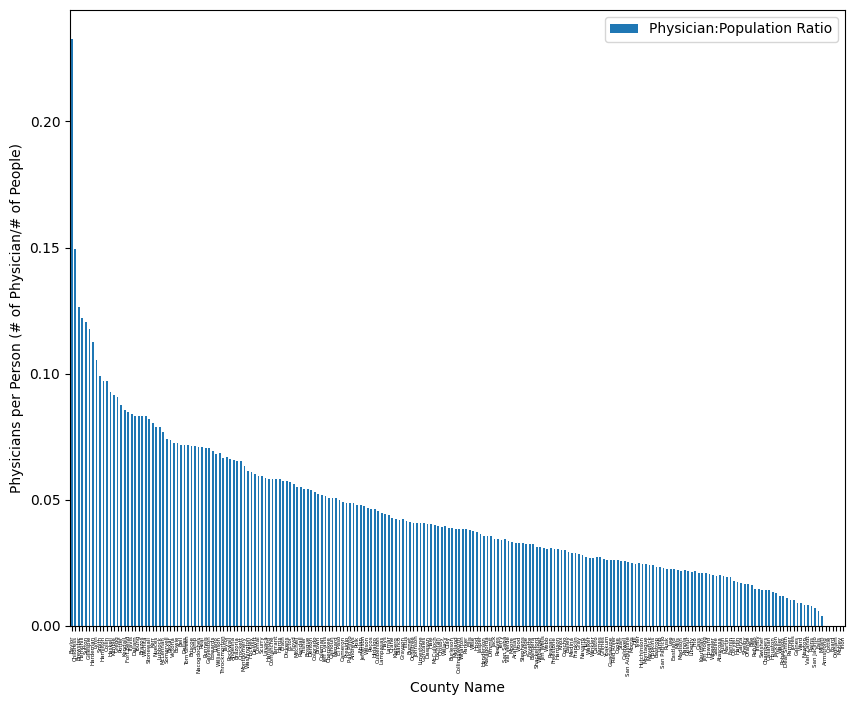

In [179]:
fig,ax = plt.subplots(figsize=(10,8))
anotherdata.plot(kind='bar', y='Physician:Population', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=4)
ax.set_xlabel('County Name')
ax.set_ylabel('Physicians per Person (# of Physician/# of People)')
ax.legend(['Physician:Population Ratio'])
plt.show()

In [197]:
dems = pd.read_csv('/Users/antoantony/Library/CloudStorage/OneDrive-TheUniversityofTexasatAustin/Python/VS_Code/Data Analysis/Disparities Dashboard/demographics.csv')
dems['COUNTYNAME'] = dems['COUNTYNAME'].str.replace('County', '',case=False).str.strip()
graphdata = pd.merge(data, dems, left_on='County (new)', right_on='COUNTYNAME', how='left')
def filter(input):
    if pd.isna(input):
        return 'Low % Minority'
    else:
        return 'High % Minority'
graphdata['% Minority'] = graphdata['COUNTYNAME'].apply(filter)
graphdata.set_index('County (new)', inplace=True)
graphdata

,County,# Primary Care Physicians,Physician:Population,National Z-Score,Unnamed: 0,COUNTYNAME,% Minority
County (new),,,,,,,
Baylor,Baylor^,8,0.2326,-3.00,NaN,NaN,Low % Minority
Childress,Childress,10,0.1493,-2.60,NaN,NaN,Low % Minority
Brewster,Brewster,12,0.1266,-2.01,9.0,Brewster,High % Minority
Hemphill,Hemphill,4,0.1220,-1.88,NaN,NaN,Low % Minority
Sutton,Sutton,4,0.1205,-1.83,NaN,NaN,Low % Minority
...,...,...,...,...,...,...,...
Cottle,Cottle,0,0.0000,1.49,NaN,NaN,Low % Minority
Foard,Foard,0,0.0000,1.49,NaN,NaN,Low % Minority
Oldham,Oldham,0,0.0000,1.49,NaN,NaN,Low % Minority


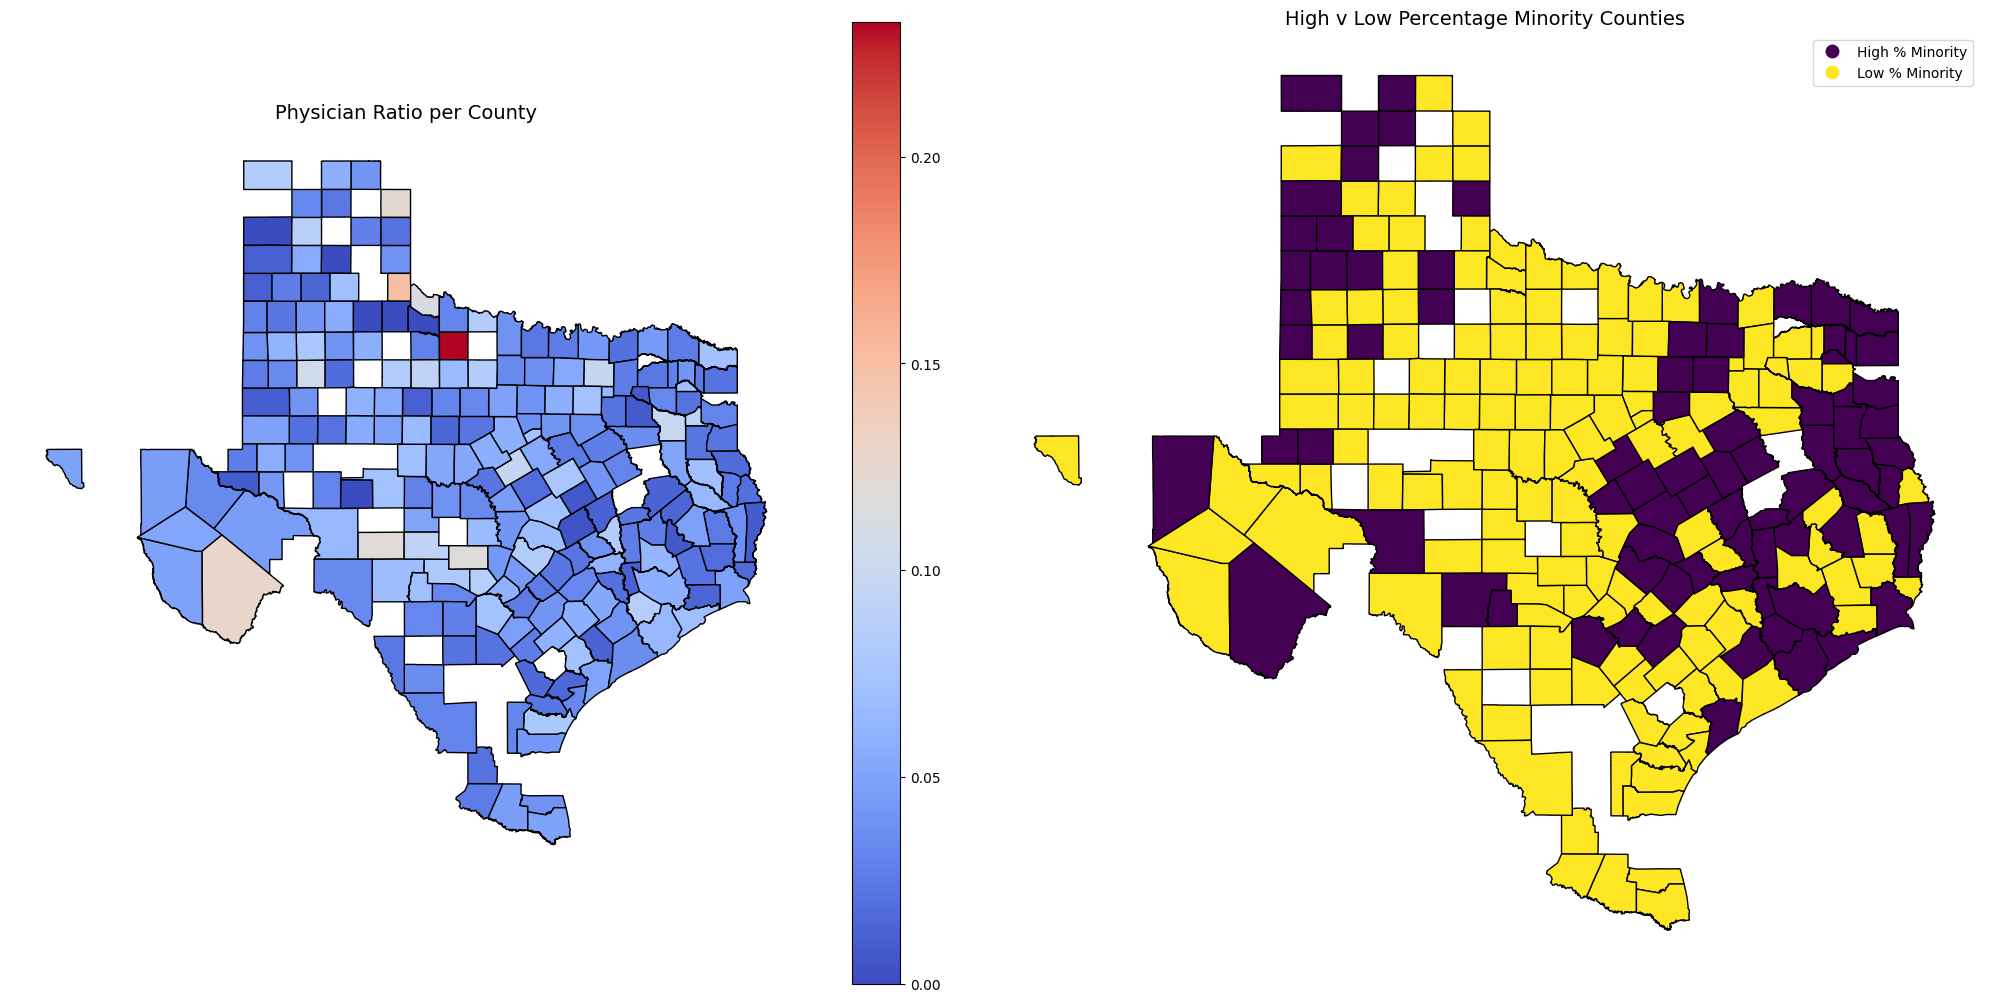

In [198]:
demographics = gpd.read_file('/Users/antoantony/Library/CloudStorage/OneDrive-TheUniversityofTexasatAustin/Python/VS_Code/Data Analysis/Disparities Dashboard/texas_shapefile.zip')
tx_counties = demographics[demographics['STATEFP'] == '48']

new_map = tx_counties.merge(graphdata, left_on='NAME', right_on='County (new)')
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
new_map.plot(column='Physician:Population', ax=axs[0], legend=True, cmap='coolwarm', edgecolor='black')
axs[0].set_title('Physician Ratio per County', fontsize=14)
axs[0].axis('off')
new_map.plot(column='% Minority', ax=axs[1], legend=True, cmap='viridis', edgecolor='black')
axs[1].set_title('High v Low Percentage Minority Counties', fontsize=14)
axs[1].axis('off')
plt.tight_layout()
plt.show()